In [1]:
from myai.imports import *
from visualbench.tasks.function_descent import FunctionDescent
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.inverse import MatrixInverse
import torchzero as tz

In [168]:
import torch
import torch.nn.functional as F
from collections import deque

class GradConvCorrOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, kernel=[0.25, 0.5, 0.25],
                 history_size=5, beta=0.1):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= beta:
            raise ValueError(f"Invalid beta coefficient: {beta}")

        defaults = dict(lr=lr, kernel=kernel, history_size=history_size, beta=beta)
        super().__init__(params, defaults)

        for group in self.param_groups:
            kernel_tensor = torch.tensor(group['kernel'], dtype=torch.float32)
            group['kernel_tensor'] = kernel_tensor.view(1, 1, -1)  # Conv1d weight format

        self._init_param_states()

    def _init_param_states(self):
        for group in self.param_groups:
            history_size = group['history_size']
            for p in group['params']:
                state = self.state[p]
                state['past_grads'] = deque(maxlen=history_size)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            kernel = group['kernel_tensor']
            history_size = group['history_size']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                # Store current gradient in history (before modification)
                state['past_grads'].append(grad.clone())

                # 1. Gradient Convolution
                # Flatten gradient for processing
                original_shape = grad.shape
                grad_flat = grad.view(-1)
                length = grad_flat.shape[0]

                # Add batch and channel dimensions for conv1d
                grad_conv = grad_flat.view(1, 1, -1)

                # Apply convolution with padding to maintain size
                pad = (kernel.shape[2] - 1) // 2
                convolved = F.conv1d(grad_conv, kernel.to(grad.device), padding=pad)

                # Reshape back to original dimensions
                convolved_grad = convolved.view(original_shape)

                # 2. Gradient Cross-Correlation
                corr_term = torch.zeros_like(grad)
                if len(state['past_grads']) > 1:  # Need at least one previous grad
                    current_grad_flat = grad_flat.detach().clone()

                    # Use all but current grad (which was just added)
                    for past_grad in list(state['past_grads'])[:-1]:
                        past_grad_flat = past_grad.view(-1)

                        # Ensure same length (handle parameter changes)
                        min_length = min(past_grad_flat.shape[0], current_grad_flat.shape[0])

                        # Compute cross-correlation coefficient
                        cc = torch.dot(
                            current_grad_flat[:min_length],
                            past_grad_flat[:min_length]
                        )

                        # Add weighted past gradient to correlation term
                        corr_term.add_(past_grad, alpha=cc.item())

                    # Normalize by number of past gradients used
                    corr_term /= max(len(state['past_grads']) - 1, 1)

                # 3. Combine components for final update
                update = convolved_grad + beta * corr_term

                # 4. Apply update
                p.data.add_(-lr * update)

        return loss

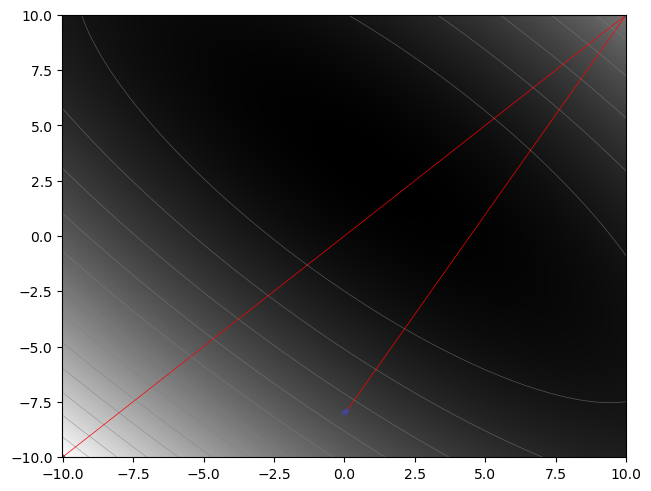

In [169]:
bench = FunctionDescent('booth')
opt = GradConvCorrOptimizer(bench.parameters(), 1e-3)
bench.run(opt, 1000,)
bench.plot_solution()

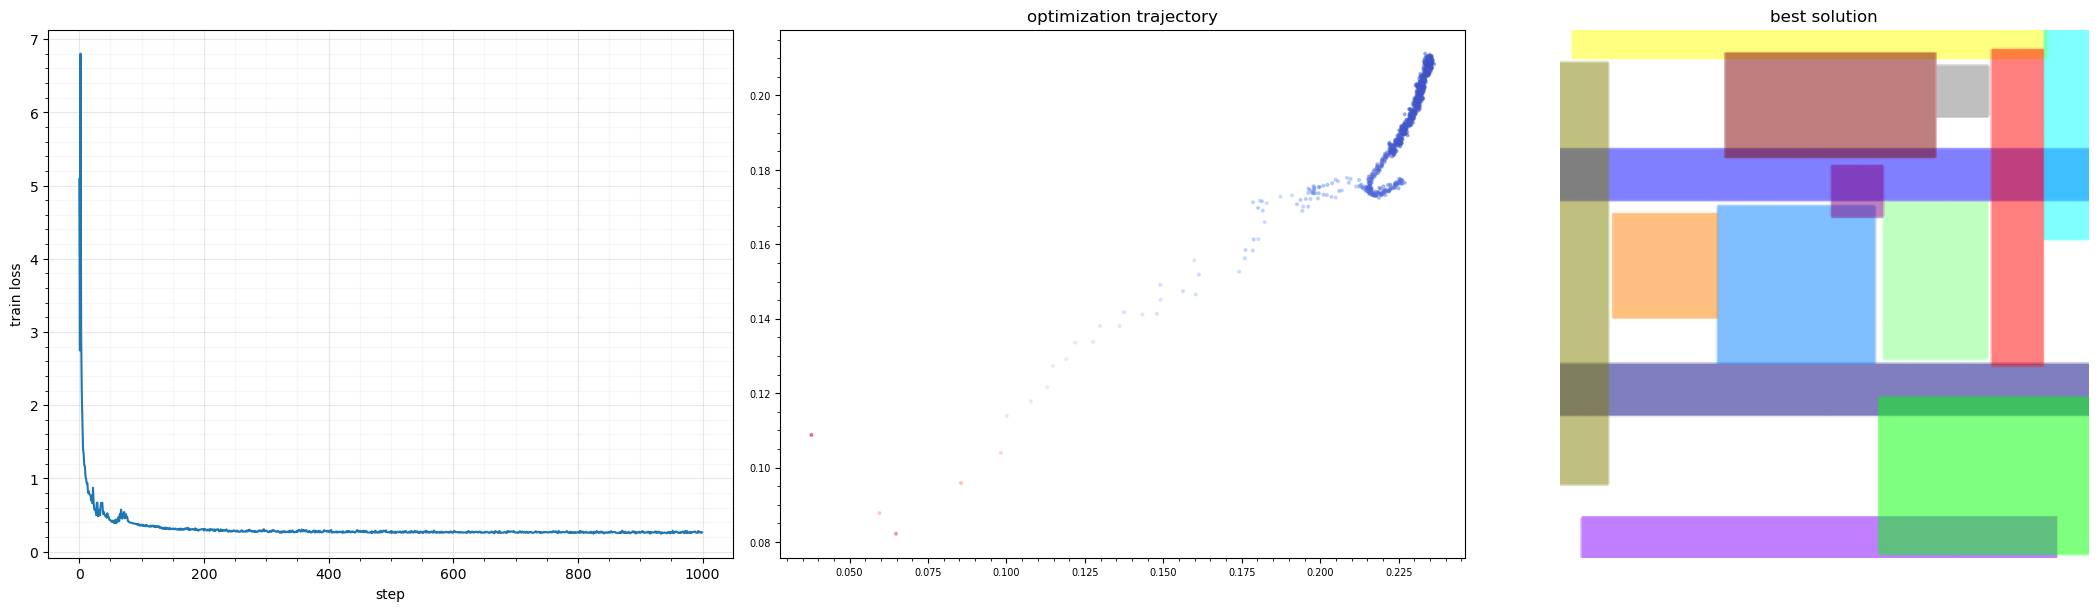

In [172]:
bench = BoxPacking()
opt = GradConvCorrOptimizer(bench.parameters(), 5e-2)
bench.run(opt, 1000,)
bench.plot_summary(1, fig=Fig().figsize(24, 6))

In [173]:
bench.render_video('GradConvCorrOptimizer')

1000/1000 | 17.94s               


image.shape = torch.Size([58, 58]), image.numel() = 3364


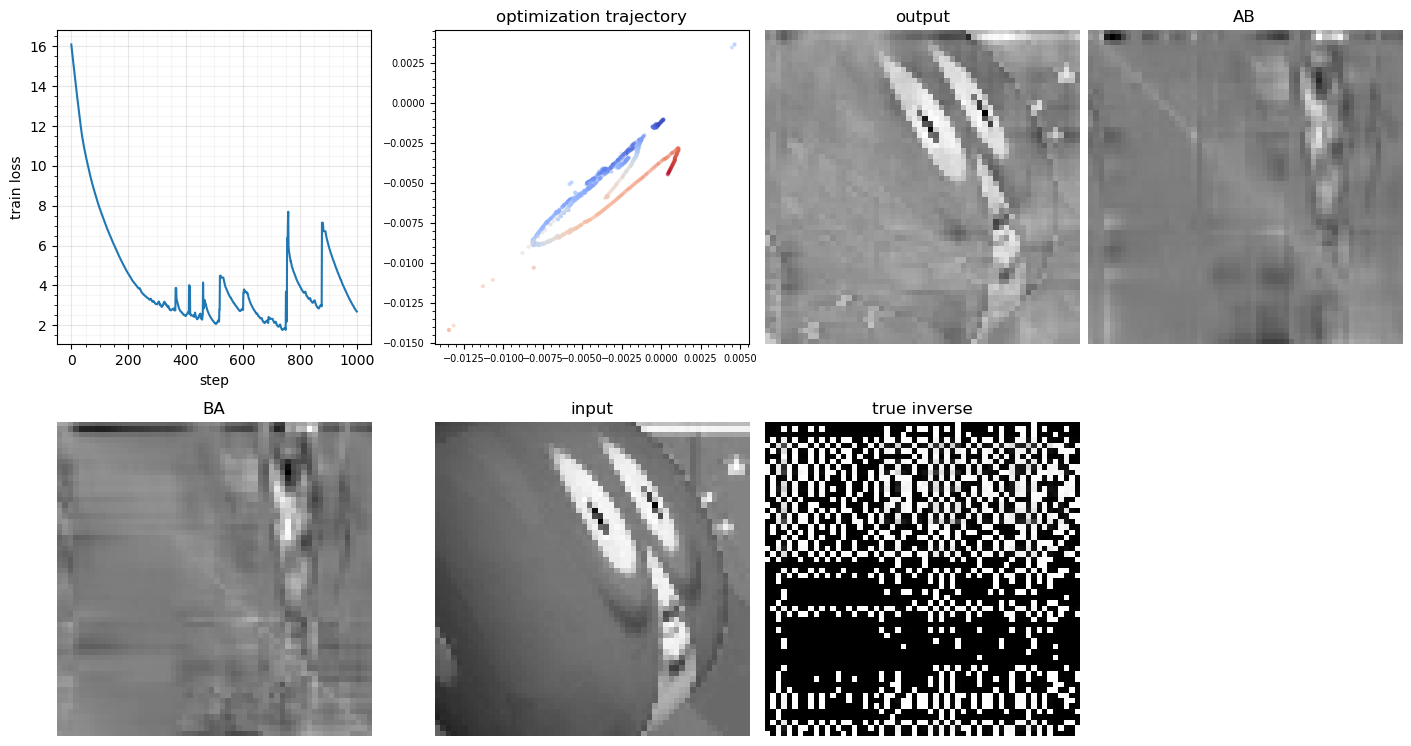

In [7]:
REDUCTION = 4
BW = True

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = GradientLossExtrapolationSGD(bench.parameters(), 1e-1, max_norm_diff=100)
bench.run(opt, 1000)
bench.plot_summary()

In [5]:
bench.render_video('glesgd inv', scale=4)

1000/1000 | 1.67s               


image.shape = torch.Size([58, 58]), image.numel() = 3364


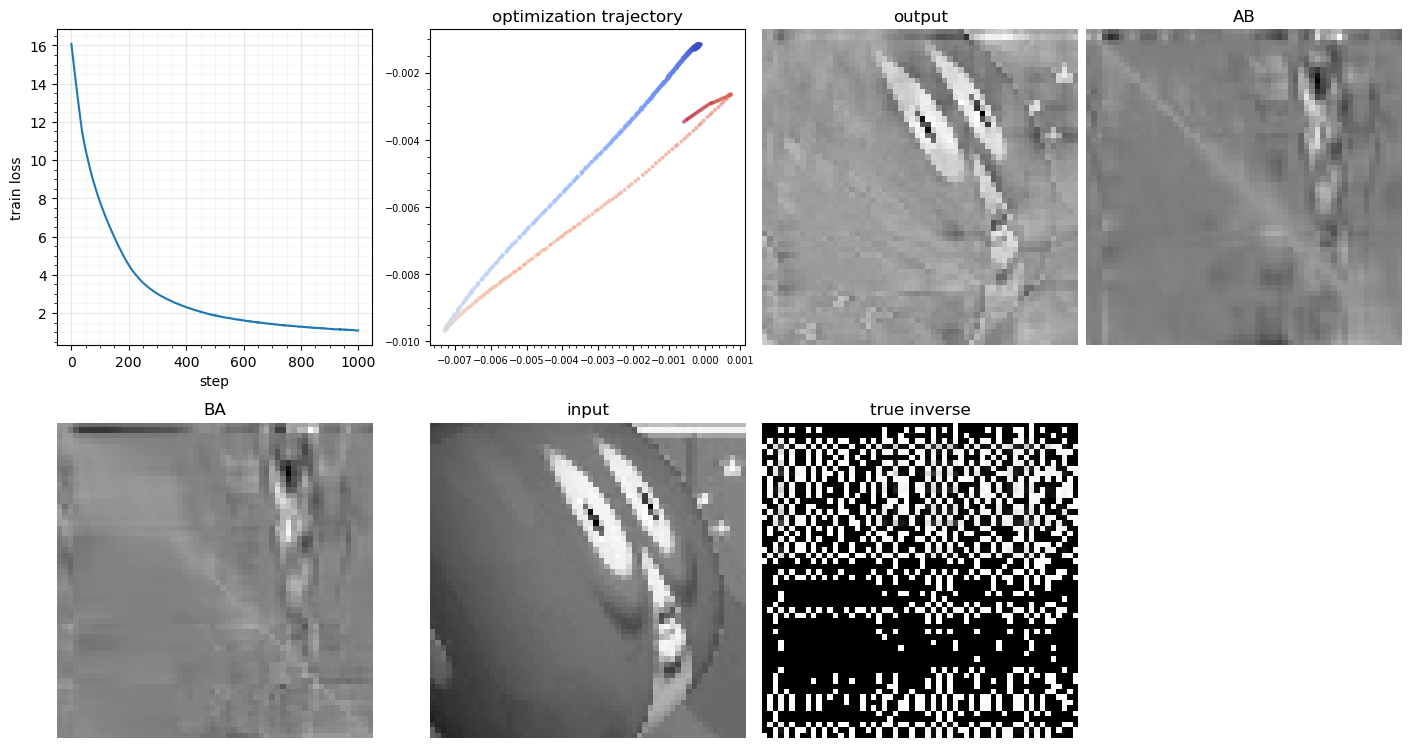

In [6]:
REDUCTION = 4
BW = True

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = torch.optim.SGD(bench.parameters(), 1e-1)
bench.run(opt, 1000)
bench.plot_summary()